# End-to-end neural functional training and prediction

In this notebook we show how to train a meta-GGA neural functional without exact-exchange end-to-end. We start loading a few modules.

In [18]:
from jax.random import split, PRNGKey
from jax import numpy as jnp
from optax import adam, apply_updates
from jax.nn import gelu

from jax.config import config
config.update("jax_enable_x64", True)

import grad_dft as gd

from pyscf import gto, dft
from tqdm import tqdm

We will use the [PySCF](https://github.com/pyscf/pyscf) package to generate the training data, in this case a single HF molecule.

In [19]:
mol = gto.M(atom="H 0 0 0; F 0 0 1.1")

grids = dft.gen_grid.Grids(mol)
grids.level = 2
grids.build()

mf = dft.UKS(mol)
mf.grids = grids
ground_truth_energy = mf.kernel()

# Then we compute quite a few properties which we pack into a class called Molecule
molecule = gd.molecule_from_pyscf(mf)

converged SCF energy = -98.2455025940388  <S^2> = 1.9548807e-12  2S+1 = 1


Next we generate the Functional. We will use an architecture similar to DM21 without the exact-exchange component, this means 

In [20]:
squash_offset = 1e-4
layer_widths = [256] * 6
out_features = 4
sigmoid_scale_factor = 2.0
activation = gelu

Remember that to generate a `NeuralFunctional` we need to define the `coefficients`, `energy_densities` and `coefficient_inputs`. For the latter two we will use the same as DM21, and manually define the neural network for the `coefficients`.
The `sow` command is not necessary but can help check that the intermediate results are correct.

In [21]:
def nn_coefficients(instance, rhoinputs, *_, **__):
    x = gd.canonicalize_inputs(rhoinputs)  # Making sure dimensions are correct

    # Initial layer: log -> dense -> tanh
    x = jnp.log(jnp.abs(x) + squash_offset)  # squash_offset = 1e-4
    instance.sow("intermediates", "log", x)
    x = instance.dense(features=layer_widths[0])(x)  # features = 256
    instance.sow("intermediates", "initial_dense", x)
    x = jnp.tanh(x)
    instance.sow("intermediates", "tanh", x)

    # 6 Residual blocks with 256-features dense layer and layer norm
    for features, i in zip(layer_widths, range(len(layer_widths))):  # layer_widths = [256]*6
        res = x
        x = instance.dense(features=features)(x)
        instance.sow("intermediates", "residual_dense_" + str(i), x)
        x = x + res  # nn.Dense + Residual connection
        instance.sow("intermediates", "residual_residual_" + str(i), x)
        x = instance.layer_norm()(x)  # + res # nn.LayerNorm
        instance.sow("intermediates", "residual_layernorm_" + str(i), x)
        x = activation(x)  # activation = jax.nn.gelu
        instance.sow("intermediates", "residual_elu_" + str(i), x)

    return instance.head(x, out_features, sigmoid_scale_factor)


functional = gd.NeuralFunctional(
    coefficients=nn_coefficients,
    energy_densities=gd.dm21_densities,
    coefficient_inputs=gd.dm21_coefficient_inputs,
)

Next we need to initialize the `NeuralFunctional` parameters. For that we need to input a matrix with the correct shape, the same as the output of the corresponding `coefficient_inputs`.

In [22]:
key = PRNGKey(42)  # Jax-style random seed

# We generate the features from the molecule we created before
rhoinputs = gd.dm21_coefficient_inputs(molecule=molecule)

# We initialize the Functional parameters
(key,) = split(key, 1)

# We make 2 copies for two separate training rounds
params = functional.init(key, rhoinputs)
scf_params = functional.init(key, rhoinputs)

## Non self-consistent training

Now we are ready to train the functional. We initialize the optimizer

In [23]:
# Then, we define the optimizer
learning_rate = 1e-4
momentum = 0.9
tx = adam(learning_rate=learning_rate, b1=momentum)
opt_state = tx.init(params)

# and number of epochs
n_epochs = 25

Then we define how the single pass energy is computed, in this case with `molecule_predictor` which is not self-consistent.

In [24]:
predict = gd.make_non_scf_predictor(functional)

Finally we can train the functional. The `simple_energy_loss` takes the `params`, `predict` object, `molecule` and corresponding `ground_truth_energy`; and returns the `loss` and `predicted_energy`, as well as the `gradient` of the `loss` with respect to the `params`.

The last two lines in the loop update the optimizer state and `params`.

In [25]:
losses = []
for iteration in tqdm(range(n_epochs), desc = 'iterations'):
    (loss, predicted_energy), grads = gd.simple_energy_loss(
        params, predict, molecule, ground_truth_energy
    )
    print("Iteration", iteration, "Predicted energy:", predicted_energy)
    losses.append(loss)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = apply_updates(params, updates)

iterations:   4%|▍         | 1/25 [00:04<01:38,  4.10s/it]

Iteration 0 Predicted energy: -126.58222116249533


iterations:   8%|▊         | 2/25 [00:07<01:23,  3.63s/it]

Iteration 1 Predicted energy: -124.41011144253119


iterations:  12%|█▏        | 3/25 [00:10<01:17,  3.52s/it]

Iteration 2 Predicted energy: -122.2198350269614


iterations:  16%|█▌        | 4/25 [00:14<01:14,  3.54s/it]

Iteration 3 Predicted energy: -120.0588842328957


iterations:  20%|██        | 5/25 [00:17<01:08,  3.44s/it]

Iteration 4 Predicted energy: -117.97161130562608


iterations:  24%|██▍       | 6/25 [00:21<01:05,  3.42s/it]

Iteration 5 Predicted energy: -115.99037094793184


iterations:  28%|██▊       | 7/25 [00:24<01:01,  3.39s/it]

Iteration 6 Predicted energy: -114.13385717504572


iterations:  32%|███▏      | 8/25 [00:27<00:57,  3.37s/it]

Iteration 7 Predicted energy: -112.41241411440677


iterations:  36%|███▌      | 9/25 [00:31<00:53,  3.37s/it]

Iteration 8 Predicted energy: -110.8331200989404


iterations:  40%|████      | 10/25 [00:34<00:50,  3.37s/it]

Iteration 9 Predicted energy: -109.40133804633663


iterations:  44%|████▍     | 11/25 [00:37<00:47,  3.36s/it]

Iteration 10 Predicted energy: -108.11954014984669


iterations:  48%|████▊     | 12/25 [00:41<00:43,  3.36s/it]

Iteration 11 Predicted energy: -106.98491941571127


iterations:  52%|█████▏    | 13/25 [00:44<00:40,  3.36s/it]

Iteration 12 Predicted energy: -105.98791855158976


iterations:  56%|█████▌    | 14/25 [00:47<00:36,  3.33s/it]

Iteration 13 Predicted energy: -105.11366782602809


iterations:  60%|██████    | 15/25 [00:51<00:33,  3.38s/it]

Iteration 14 Predicted energy: -104.3454587302345


iterations:  64%|██████▍   | 16/25 [00:54<00:30,  3.36s/it]

Iteration 15 Predicted energy: -103.66756903751623


iterations:  68%|██████▊   | 17/25 [00:57<00:26,  3.31s/it]

Iteration 16 Predicted energy: -103.06636228550838


iterations:  72%|███████▏  | 18/25 [01:01<00:23,  3.34s/it]

Iteration 17 Predicted energy: -102.53032218686076


iterations:  76%|███████▌  | 19/25 [01:04<00:19,  3.31s/it]

Iteration 18 Predicted energy: -102.04979766812596


iterations:  80%|████████  | 20/25 [01:07<00:16,  3.30s/it]

Iteration 19 Predicted energy: -101.61675655960839


iterations:  84%|████████▍ | 21/25 [01:11<00:13,  3.43s/it]

Iteration 20 Predicted energy: -101.22457633687915


iterations:  88%|████████▊ | 22/25 [01:14<00:10,  3.37s/it]

Iteration 21 Predicted energy: -100.86784942543805


iterations:  92%|█████████▏| 23/25 [01:18<00:06,  3.40s/it]

Iteration 22 Predicted energy: -100.54219460409625


iterations:  96%|█████████▌| 24/25 [01:22<00:03,  3.61s/it]

Iteration 23 Predicted energy: -100.2440780088875


iterations: 100%|██████████| 25/25 [01:26<00:00,  3.48s/it]

Iteration 24 Predicted energy: -99.97064988202253


We can now use the `NeuralFunctional` functionality to save a checkpoint of the training.

In [26]:
functional.save_checkpoints(params, tx, step=n_epochs)

We can also plot the loss

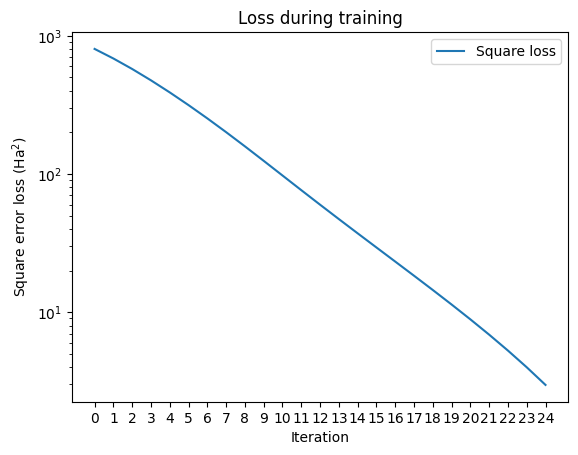

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(losses, label="Square loss")
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Square error loss (Ha$^2$)")

# Set x labels at integer values
import numpy as np

ax.set_xticks(np.arange(0, n_epochs, 1.0))

ax.set_title("Loss during training")

ax.set_yscale("log")

ax.legend()

## Self-consistent loop prediction

We can also used the trained functional to compute the energy of the molecule

In [28]:
predicted_energy = functional.energy(params, molecule)
print("Predicted_energy:", predicted_energy)

Predicted_energy: -99.71960153224379


Which step by step is being computed as

In [29]:
# We generate the input densities from the molecule we created before
densities = functional.energy_densities(molecule)
# We now generated the inputs to the coefficients nn
coefficient_inputs = functional.coefficient_inputs(molecule)
# We can use this features to compute the energy by parts
predicted_energy = functional.xc_energy(
    params, molecule.grid, coefficient_inputs, densities
)
predicted_energy += molecule.nonXC()
print("Predicted_energy:", predicted_energy)

Predicted_energy: -99.71960153224379


We can now implement a self consistent loop to compute the energy of the molecule. For that we first load the saved checkpoint

In [30]:
train_state = functional.load_checkpoint(
    tx, ckpt_dir="ckpts/checkpoint_" + str(n_epochs) + "/", step=n_epochs
)
params = train_state.params
tx = train_state.tx
opt_state = tx.init(params)

Then we can create the scf iteration object

In [31]:
scf_iterator = gd.make_scf_loop(functional, verbose=2, cycles = 10)

and use to compute the energy, outputing a `Molecule` instance with the `energy` attribute set to the predicted energy of the molecule.

In [32]:
modified_molecule = scf_iterator(params, molecule)
print(f"The predicted energy is {modified_molecule.energy}")


SCF not converged.
SCF energy = -98.1437213127202
cycle: 0, energy: -9.9728422e+01, energy difference: 8.8204e-03, norm_gradient_orbitals: 2.66e-02, seconds: 2.4e+00
cycle: 1, energy: -9.9761864e+01, energy difference: 3.3442e-02, norm_gradient_orbitals: 1.65e-02, seconds: 2.3e+00
cycle: 2, energy: -9.9764396e+01, energy difference: 2.5319e-03, norm_gradient_orbitals: 3.11e-02, seconds: 2.1e+00
cycle: 3, energy: -9.9765621e+01, energy difference: 1.2256e-03, norm_gradient_orbitals: 4.45e-02, seconds: 3.7e+00
cycle: 4, energy: -9.9759665e+01, energy difference: 5.9569e-03, norm_gradient_orbitals: 7.20e-02, seconds: 3.0e+00
cycle: 5, energy: -9.9758833e+01, energy difference: 8.3152e-04, norm_gradient_orbitals: 6.14e-02, seconds: 3.2e+00
cycle: 6, energy: -9.9765185e+01, energy difference: 6.3522e-03, norm_gradient_orbitals: 2.07e-02, seconds: 2.8e+00
cycle: 7, energy: -9.9764861e+01, energy difference: 3.2424e-04, norm_gradient_orbitals: 3.59e-02, seconds: 2.5e+00
cycle: 8, energy: -9.9

This will coincide with the differentiable scf loop result. We initialize the iterator.

In [33]:
scf_iterator = gd.make_jitted_scf_loop(functional, cycles = 10)

and execute it.

In [34]:
modified_molecule = scf_iterator(params, molecule)
print(f"The predicted energy is {modified_molecule.energy}")

The predicted energy is -99.76659124061376
